In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
x, y = pkl.load(open('dataset/samples.pkl', 'rb'))

print(x.shape, y.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/samples.pkl'

In [ ]:
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

-46.06486893 43.00866699 -0.52579503197042 5.176231116713095
-29.88856888 34.09674835 2.584682740273537 7.962828151857226
-75.55059814 86.84925079 -0.11620588007315523 13.090839183150852


In [ ]:
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

-46.06486893 43.00866699 -0.52579503197042 5.176231116713095
-29.88856888 34.09674835 2.584682740273537 7.962828151857226
-75.55059814 86.84925079 -0.11620588007315523 13.090839183150852


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4401, 2278) (4401, 3)
(943, 2278) (943, 3)
(944, 2278) (944, 3)


In [ ]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
model = Sequential()
model.add(Dense(units=20, activation='relu', kernel_regularizer='l2', input_dim=x.shape[1]))
model.add(Dense(units=10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=3, activation='linear'))

print(model.summary())

callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callback_list)
model.save('models/model.h5')

print()
print('Train loss:', model.evaluate(x_train, y_train, verbose=0))
print('  Val loss:', model.evaluate(x_val, y_val, verbose=0))
print(' Test loss:', model.evaluate(x_test, y_test, verbose=0))

In [ ]:
history = hist.history
loss_train = history['loss']
loss_val = history['val_loss']

plt.figure()
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val_loss', color='red')
plt.legend()

In [ ]:
y_pred = model.predict(x_test)
diff = y_test - y_pred
diff_roll = diff[:, 0]
diff_pitch = diff[:, 1]
diff_yaw = diff[:, 2]

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(diff_roll, color='red')
plt.title('roll')

plt.subplot(3, 1, 2)
plt.plot(diff_pitch, color='red')
plt.title('pitch')

plt.subplot(3, 1, 3)
plt.plot(diff_yaw, color='red')
plt.title('yaw')

plt.tight_layout()

In [ ]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    # assert (len(face_points) == 68), "len(face_points) must be 68"
    if len(face_points)!=68:
        return None
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

time1  0.6762516498565674
time2  0.0032930374145507812
time3  0.013066291809082031
time4  0.2553133964538574
 Roll: -0.97°
Pitch: 1.50°
  Yaw: -3.46°


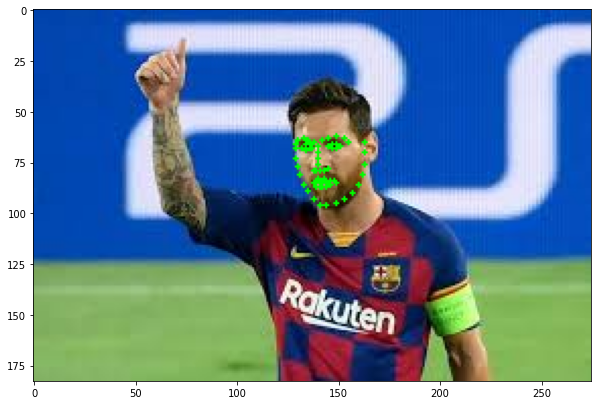

In [ ]:

import time
# im = cv2.imread('face-recognition-test/processed_data/train1/Hoang Ngoc/IMG_20200611_104305.jpg', cv2.IMREAD_COLOR)
# im = cv2.imread('datatmp/img_in_sec.jpg', cv2.IMREAD_COLOR)
model = load_model('models/model.h5')
im = cv2.imread('face-recognition-test/img1.jpg', cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
t1 = time.time()
face_points = detect_face_points(im)
t2 = time.time()
print('time1 ', t2-t1)
for x, y in face_points:
    cv2.circle(im, (x, y), 1, (0, 255, 0), -1)

t3 = time.time()
print('time2 ', t3-t2)


features = compute_features(face_points)
features = std.transform(features)

t4 = time.time()
print('time3 ', t4-t3)


y_pred = model.predict(features)

t5 = time.time()
print('time4 ', t5-t4)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print(' Roll: {:.2f}°'.format(roll_pred))
print('Pitch: {:.2f}°'.format(pitch_pred))
print('  Yaw: {:.2f}°'.format(yaw_pred))
    
plt.figure(figsize=(10, 10))
plt.imshow(im)

In [ ]:
# camera = cv2.VideoCapture(0)
# model = load_model('models/model.h5')
# while True:
#     ret, frame = camera.read()
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     face_points = detect_face_points(im)

#     for x, y in face_points:
#         cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    
#     features = compute_features(face_points)
#     if not isinstance(features, np.ndarray):
#         cv2.imshow('camera', frame)
#         continue
#     features = std.transform(features)

    
    # y_pred = model.predict(features)

    # roll_pred, pitch_pred, yaw_pred = y_pred[0]
    # roll = (' Roll: {:.2f}°'.format(roll_pred))
    # pitch = ('Pitch: {:.2f}°'.format(pitch_pred))
    # yaw = ('  Yaw: {:.2f}°'.format(yaw_pred))

    # cv2.putText(frame, roll, (10, 100), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
    #                 color=(255, 0, 0), thickness=1)
    # cv2.putText(frame, pitch, (10, 200), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
    #                 color=(255, 0, 0), thickness=1)
    # cv2.putText(frame, yaw, (10, 300), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
    #                 color=(255, 0, 0), thickness=1)

    # cv2.imshow('camera', frame)
    # key = cv2.waitKey(1)
    # if key == 27:
    #     break
